# RNN
Since RNNs are particularly useful for sequence data, we can treat the audio as a sequence of frames or windows of features extracted over time, which will allow the RNN to capture temporal dependencies in the audio.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import pandas as pd
import numpy as np
import os


## Preprocess Data
We will extract sequences of features from the audio files (e.g., amplitude, spectral centroid, etc.) to feed into the RNN.

In [4]:
# Path to the normalized audio folder
audio_folder = '../dataset_normalized'

# Function to extract sequential audio features
def extract_sequential_features(file_path, sr=22050, n_mfcc=13):
    y, _ = librosa.load(file_path, sr=sr)

    # Extract MFCCs as a sequence of features (you can use other features as well)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Return the transposed MFCC (shape will be [sequence_length, n_mfcc])
    return mfcc.T

# Load your labels CSV
labels_df = pd.read_csv('audio_durations_labels.csv')

# Create a custom dataset class for PyTorch
class AudioDataset(Dataset):
    def __init__(self, audio_folder, labels_df, n_mfcc=13):
        self.audio_folder = audio_folder
        self.labels_df = labels_df
        self.n_mfcc = n_mfcc

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        file_name = self.labels_df.iloc[idx]['file_name']
        label = self.labels_df.iloc[idx]['label']

        # Map label to numerical values (short=0, medium=1, long=2)
        label_map = {'short': 0, 'medium': 1, 'long': 2}
        label = label_map[label]

        # Load the audio file and extract sequential features (MFCCs)
        file_path = os.path.join(self.audio_folder, file_name)
        features = extract_sequential_features(file_path, n_mfcc=self.n_mfcc)

        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create an instance of the dataset
audio_dataset = AudioDataset(audio_folder, labels_df)

# Create a DataLoader
batch_size = 16
data_loader = DataLoader(audio_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)


## Define the RNN Model
We will define an RNN using nn.RNN or nn.LSTM in PyTorch, as RNNs or LSTMs are more suited to sequential data.

In [5]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # Use LSTM or RNN
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # For LSTM

        # Forward propagate the RNN
        out, _ = self.rnn(x, (h0, c0))  # Use (h0, c0) for LSTM, just h0 for RNN

        # Take the output from the last time step
        out = out[:, -1, :]

        # Pass the last output through the fully connected layer
        out = self.fc(out)
        return out


## Train the Model
Now, we’ll set up the training loop, define the loss function, and use an optimizer to train the RNN.

In [6]:
# Hyperparameters
input_size = 13  # Number of MFCC features
hidden_size = 128
num_layers = 2
num_classes = 3  # short, medium, long
learning_rate = 0.001
num_epochs = 10

# Initialize the model, loss function, and optimizer
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in data_loader:
        # Get features and labels from the batch
        features, labels = zip(*batch)
        features = nn.utils.rnn.pad_sequence(features, batch_first=True).to(device)
        labels = torch.tensor(labels).to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.6779
Epoch [2/10], Loss: 0.7770
Epoch [3/10], Loss: 0.7461
Epoch [4/10], Loss: 0.7127
Epoch [5/10], Loss: 0.5693
Epoch [6/10], Loss: 0.9309
Epoch [7/10], Loss: 0.7116
Epoch [8/10], Loss: 0.3506
Epoch [9/10], Loss: 0.4424
Epoch [10/10], Loss: 0.4438


## Evaluate the Model
After training, we will evaluate the RNN on the test set and calculate accuracy, precision, and recall.

In [7]:
# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in data_loader:
        features, labels = zip(*batch)
        features = nn.utils.rnn.pad_sequence(features, batch_first=True).to(device)
        labels = torch.tensor(labels).to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 92.20%


## Visualization

- Evaluate the model on the test set to get predictions.
- Calculate key metrics such as accuracy, precision, recall, and F1-score.
- Plot a confusion matrix to visualize how well the model is performing on each class.

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

              precision    recall  f1-score   support

       short       0.90      1.00      0.95        46
      medium       1.00      0.66      0.79        29
        long       0.91      1.00      0.95        48

    accuracy                           0.92       123
   macro avg       0.94      0.89      0.90       123
weighted avg       0.93      0.92      0.91       123



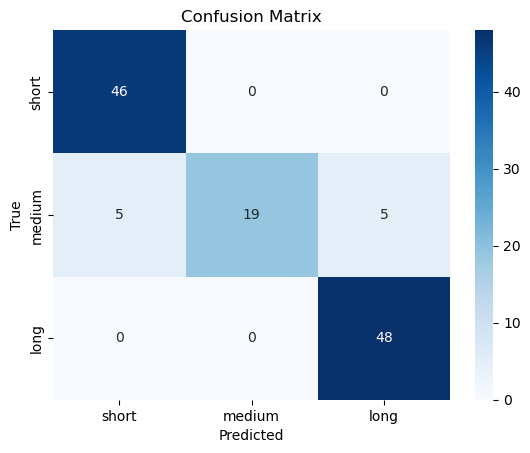

In [14]:
# Assuming labels_df contains all data
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Dataset and DataLoader for the training set
train_dataset = AudioDataset(audio_folder, train_df, n_mfcc=13)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Dataset and DataLoader for the test set
test_dataset = AudioDataset(audio_folder, test_df, n_mfcc=13)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


y_true, y_pred = evaluate_model(model, test_loader, device)

# Metrics Report
print(classification_report(y_true, y_pred, target_names=['short', 'medium', 'long']))

# Visualized confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['short', 'medium', 'long'], yticklabels=['short', 'medium', 'long'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Let It Flow Web App - Export Model to use in the Web App

In [16]:
# Save the trained model
model_save_path = '../models/rnn_labeled_pouring_model_lina.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to ../models/rnn_labeled_pouring_model_lina.pth


# Let It Flow Web App - Export to ONNX

In [17]:
# Dummy input that matches the input size of your model
dummy_input = torch.randn(1, 100, input_size).to(device)  # Example: sequence length of 100

# Export the model to ONNX format
torch.onnx.export(
    model,  # Your trained model
    dummy_input,  # Dummy input to define the input shape
    "rnn_model.onnx",  # Output file name
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,  # ONNX version
    input_names=['input'],  # Name for the input layer
    output_names=['output'],  # Name for the output layer
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Handle dynamic batch size
)

print("Model has been successfully exported to ONNX format.")


Model has been successfully exported to ONNX format.


/opt/homebrew/Caskroom/miniforge/base/envs/aicp/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
